In [75]:
!pwd

/content


In [76]:
!mkdir /content/human_segmentation

mkdir: cannot create directory ‘/content/human_segmentation’: File exists


In [77]:
!mkdir /content/human_segmentation/models

mkdir: cannot create directory ‘/content/human_segmentation/models’: File exists


In [78]:
!mkdir /content/human_segmentation/images

mkdir: cannot create directory ‘/content/human_segmentation/images’: File exists


In [79]:
!mv /content/5204363622803969062.jpg /content/human_segmentation/images

mv: cannot stat '/content/5204363622803969062.jpg': No such file or directory


In [80]:
!pip install opencv-python pixellib

In [81]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


이미지 크기: (1280, 755, 3)


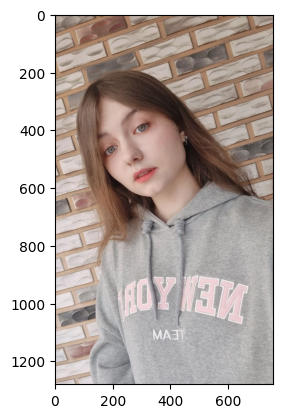

In [82]:
img_orig = cv2.imread('/content/human_segmentation/images/5204363622803969062.jpg')

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [83]:
model=deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
transform=T.Compose([
    T.ToPILImage(),
    T.Resize((520,520)),
    T.ToTensor(),

])

In [85]:
input_tensor=transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [86]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

In [87]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

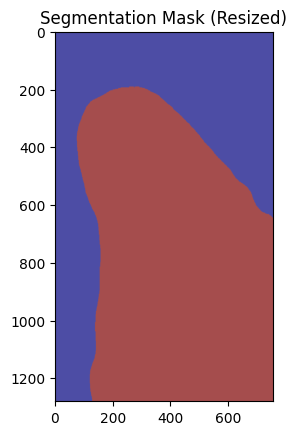

In [88]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [89]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [90]:
for class_id in unique_classes:
  print(LABEL_NAMES[class_id])

background
person


In [91]:
colormap=np.zeros((256,3), dtype=int)
ind=np.arange(256, dtype=int)

In [92]:
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

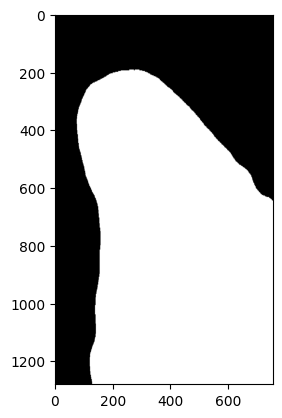

In [93]:
seg_map=(output_predictions_resized==15)
img_mask=seg_map.astype(np.uint8)*255
color_mask=cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')

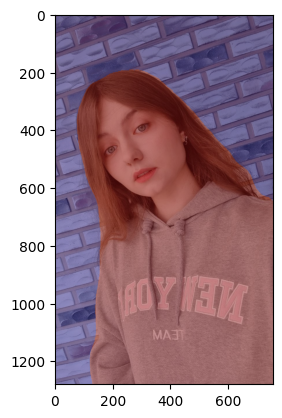

In [94]:
img_show=cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

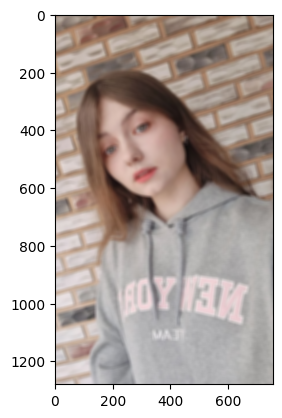

In [95]:
img_orig_blur=cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))

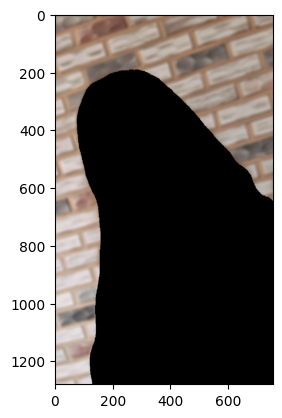

In [96]:
img_mask_color=cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask=cv2.bitwise_not(img_mask_color)
img_bg_blur=cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

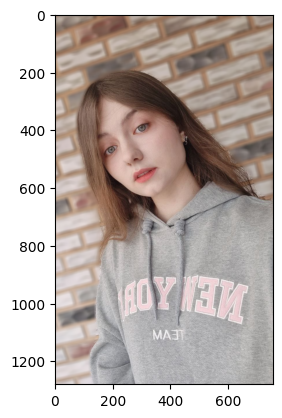

In [97]:
img_concat=np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

# 배경전환

원본 고양이 이미지 크기: (1200, 1600, 3)
배경(사막) 이미지 크기: (1080, 1920, 3)


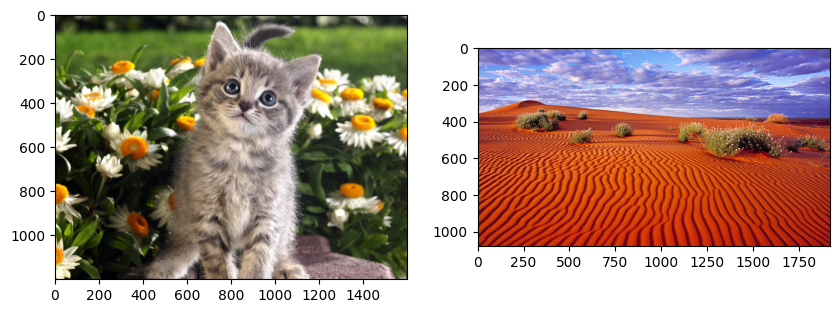

In [98]:
cat_img_path = "/content/cat.jpg"
sand_img_path = "/content/sand.jpg"

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [99]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [100]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (1200, 1600)


In [101]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0  8 16]


In [102]:
for class_id in unique_classes:
  print(LABEL_NAMES[class_id])

background
cat
pottedplant


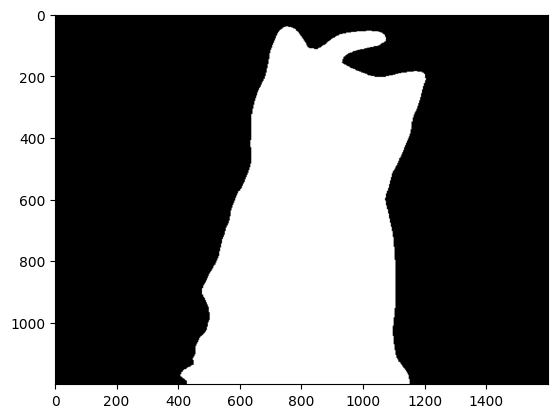

In [103]:
target_class_id = unique_classes[1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

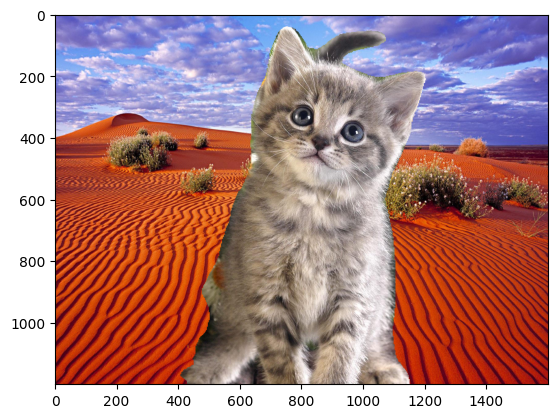

In [104]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# 동물

In [105]:
img_orig=cv2.imread('/content/horse.jpg')
input_tensor=transform(img_orig).unsqueeze(0)


with torch.no_grad():
    output=model(input_tensor)['out'][0]
    output_predictions=output.argmax(0).byte().cpu().numpy()

output_prediction_resized1=cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

In [106]:
print(np.unique(output_prediction_resized1))


[ 0 13]


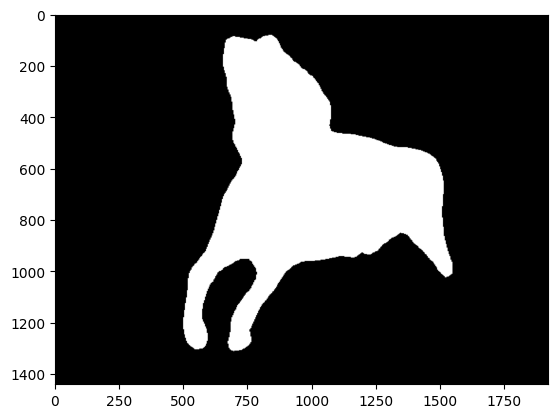

In [107]:
seg_map=(output_prediction_resized1==13)
img_mask=seg_map.astype(np.uint8)*255
color_mask=cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')

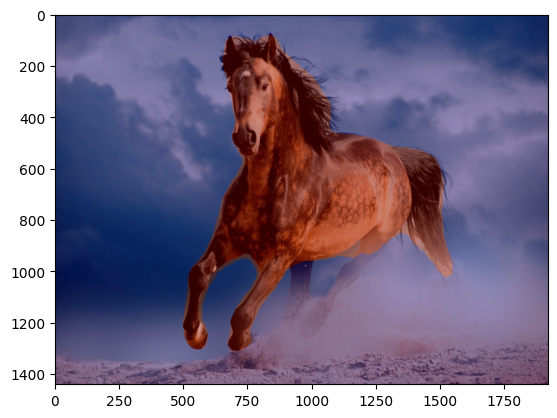

In [108]:
img_show=cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

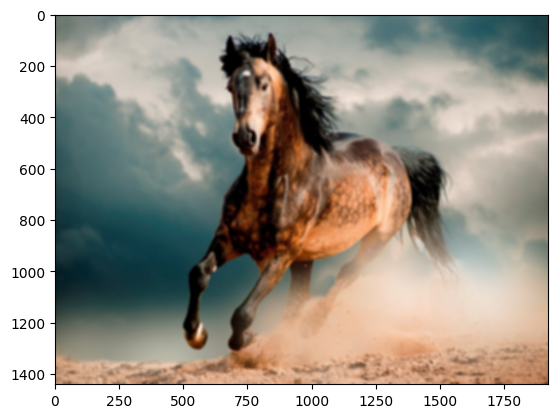

In [109]:
img_orig_blur=cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))

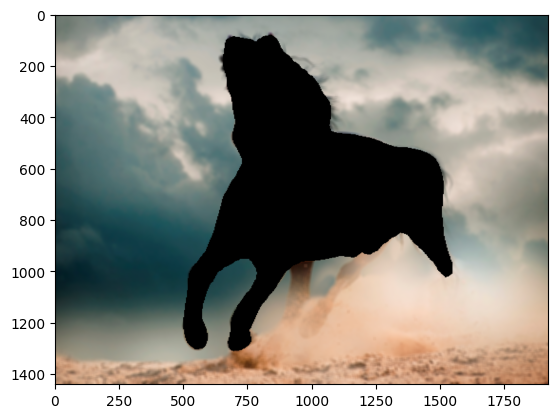

In [110]:
img_mask_color=cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask=cv2.bitwise_not(img_mask_color)
img_bg_blur=cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

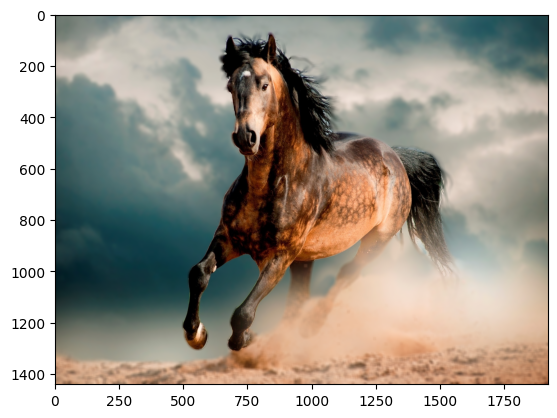

In [111]:
img_concat=np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

# 함수로 만든다


In [112]:
def portrait_mode(path, model):
  img_orig=cv2.imread(path)
  h,w=img_orig.shape[:2]
  transform=T.Compose([
      T.ToPILImage(),
      T.Resize((520,520)),
      T.ToTensor()
  ])

  inp=transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)
  with torch.inference_mode():
    output=model(inp)['out'][0]
  pred=output.argmax(0).byte().cpu().numpy()
  mask=cv2.resize(pred, (w,h), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

  uniq=np.unique(mask)
  obj_classes=uniq[uniq!=0]
  if len(obj_classes)>1:
    counts = [(cls, np.sum(mask == cls)) for cls in obj_classes]
    target_class = max(counts, key=lambda x: x[1])[0]
  else:
    target_class = int(obj_classes[0])

  seg=(mask==target_class).astype(np.uint8)*255
  color_mask=cv2.applyColorMap(seg, cv2.COLORMAP_JET)
  overlay_mask=cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

  bg_blur=cv2.blur(img_orig, (13,13))
  seg_color=cv2.cvtColor(seg, cv2.COLOR_GRAY2BGR)
  bg_mask=cv2.bitwise_not(seg_color)
  bg_part=cv2.bitwise_and(bg_blur, bg_mask)

  obj_part=np.where(seg_color==255, img_orig, bg_part)
  plt.figure(figsize=(6,6))
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(overlay_mask, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(obj_part, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()



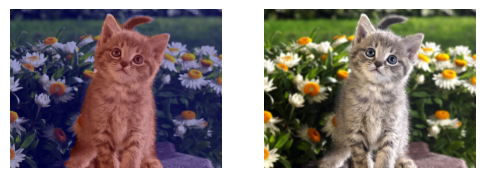

In [113]:
portrait_mode('/content/cat.jpg', model)

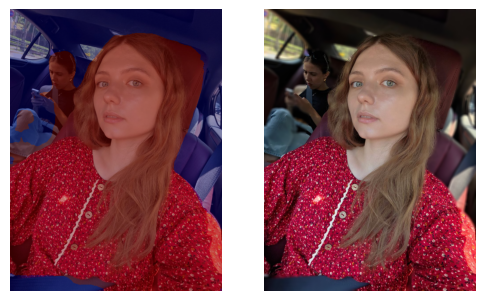

In [114]:
portrait_mode('/content/5208867222431329885.jpg', model)

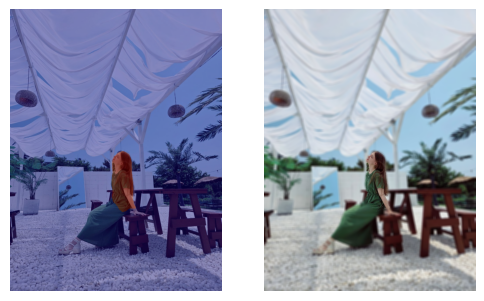

In [115]:
portrait_mode('/content/5208867222431329886.jpg', model)

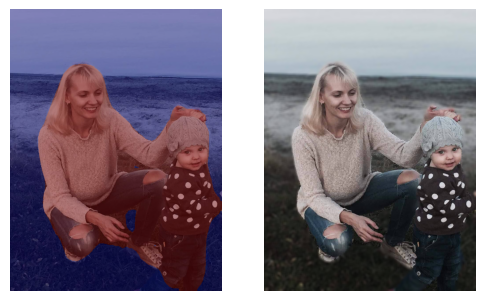

In [116]:
portrait_mode('/content/5208867222431329891.jpg', model)

# 문제가 되는 상황

문제: 사진 속 객체가 가까이 있지 않고 멀리 있을 경우 세그멘테이션이 제대로 이루어지지 않습니다.

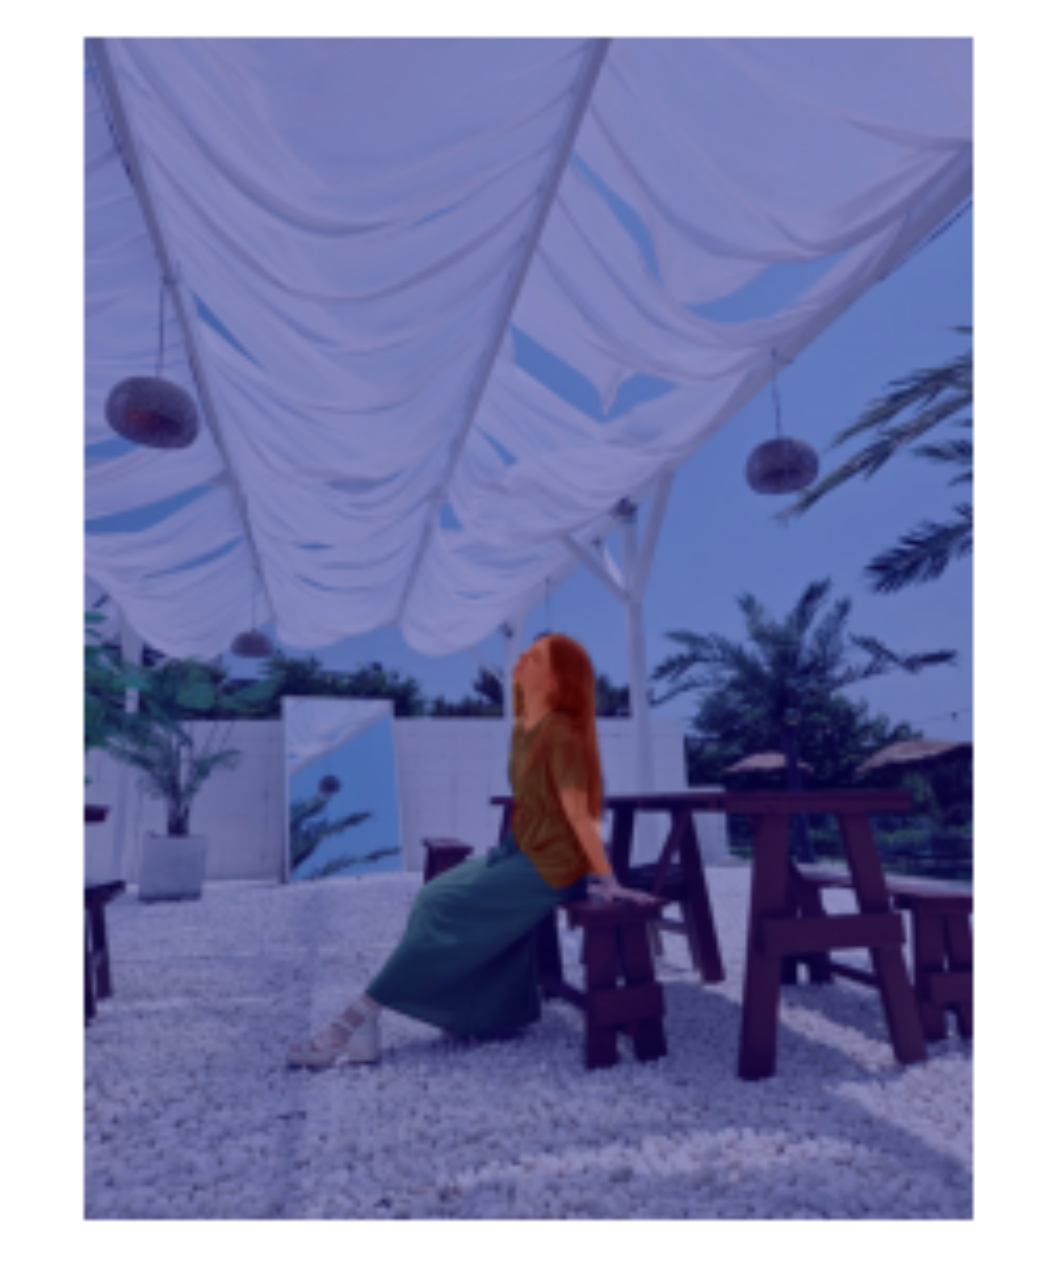







**문제: 객체의 색상이 배경 색상과 유사할 경우 배경의 일부가 객체로 인식되어 마스크에 포함됩니다.**

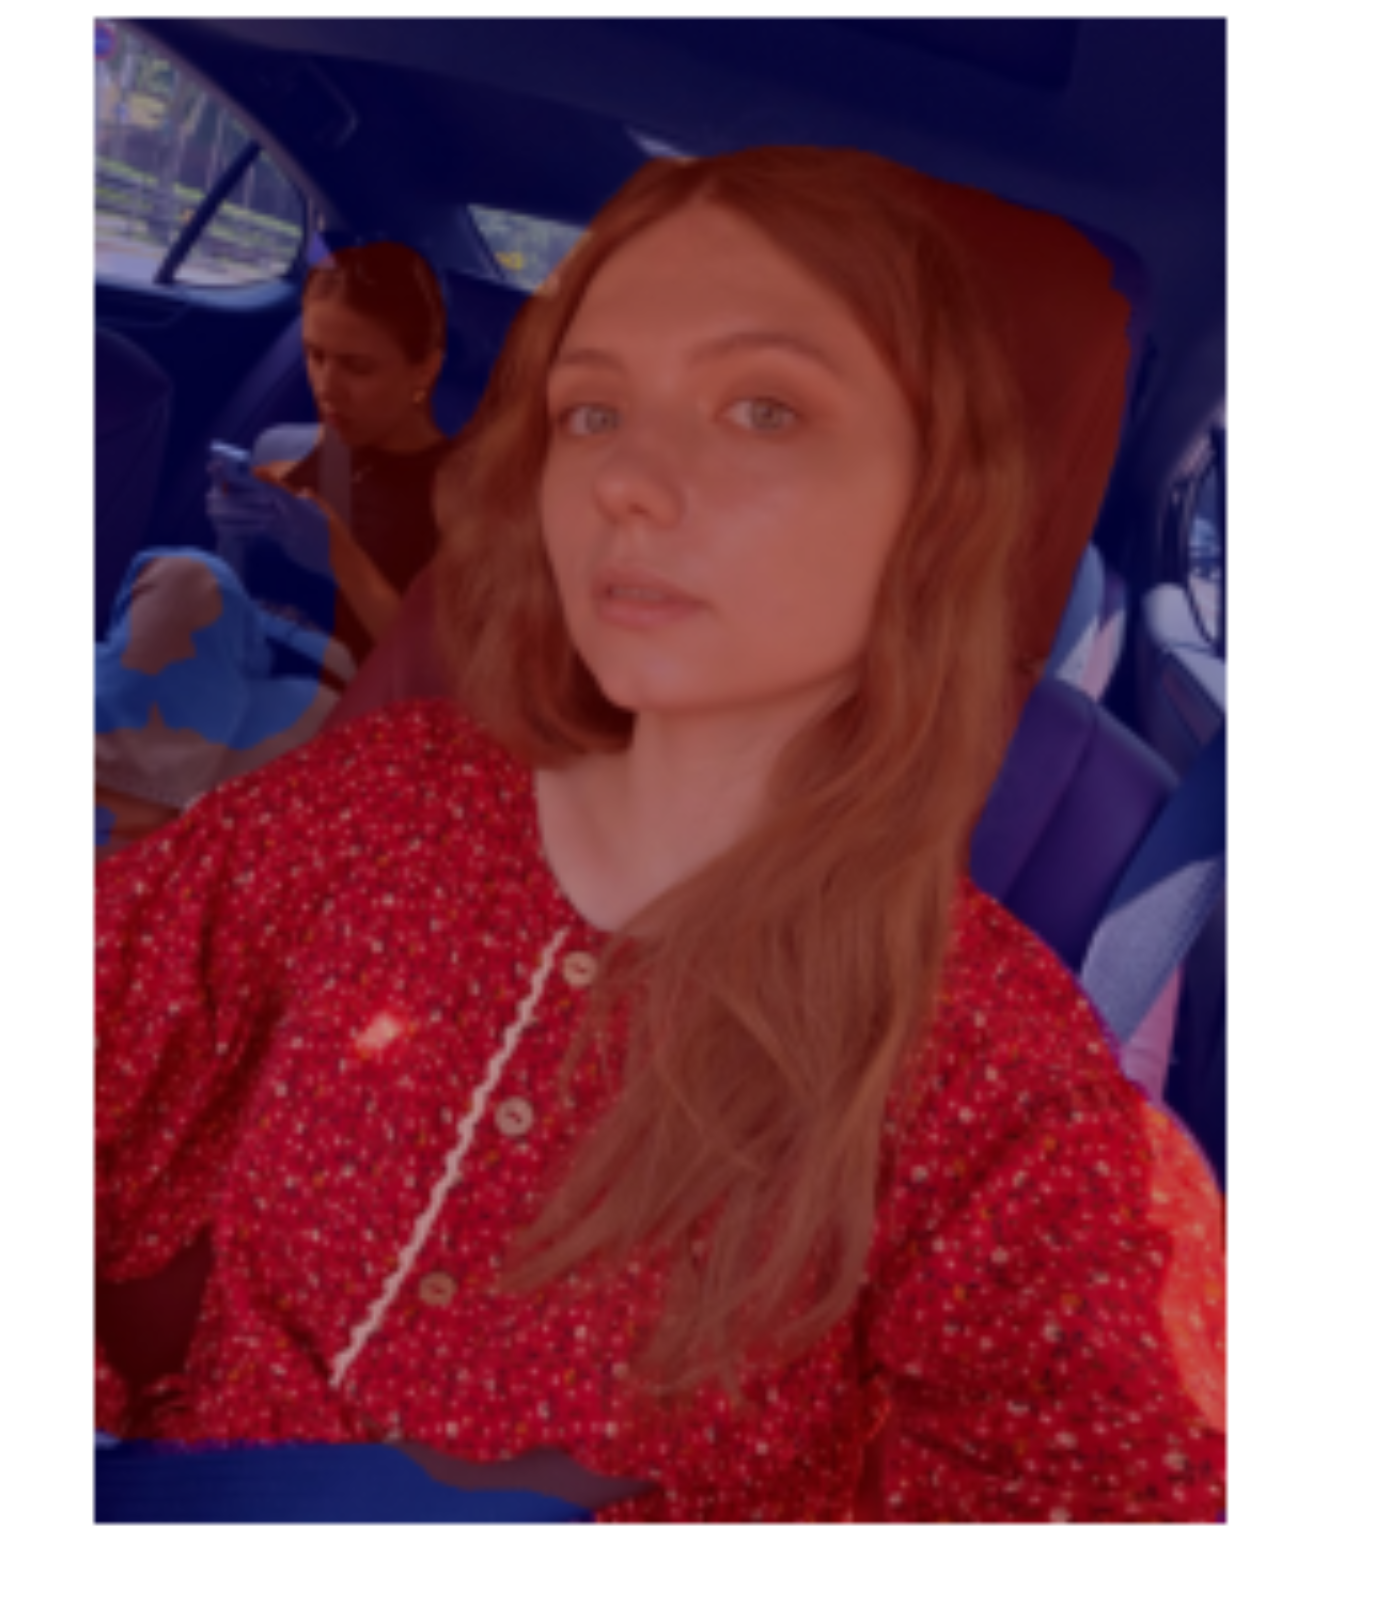

1. 객체가 멀리 있어서 세그멘테이션이 잘 안 되는 문제

원인: 입력 이미지를 줄이는 과정에서 객체의 디테일이 손실되고, 배경 비율이 커지면서 모델이 객체를 잘 인식하지 못함.

**해결 방안:**

모델 입력 전 객체 영역 크롭 후 리사이즈

사람을 중심으로 영역을 잘라낸 뒤 세그멘테이션 수행 → 객체가 더 크게 입력됨.

멀티 스케일 추론(Multi-scale inference)
이미지를 0.5배, 1배, 1.5배 등 다양한 크기로 추론 후 결과를 합성.

원거리 객체가 포함된 데이터로 파인튜닝
멀리 있는 객체 사진을 추가 학습시켜 모델 적응력 강화.

 2. 객체 색상이 배경과 유사하여 배경 일부가 마스크에 포함되는 문제

원인: 모델이 주로 색상과 텍스처를 기반으로 구분하기 때문에 유사한 색상에서 오류 발생.

**해결 방안:**

후처리 기법 적용 (DenseCRF, Guided Filter)
경계 정보를 활용해 배경 픽셀을 제거하고 마스크를 정교화.

깊이 정보 활용 (Depth Estimation 또는 3D 센서)
색상이 비슷해도 깊이 차이로 객체와 배경을 구분 가능.

구조 기반 모델 사용 (Mask R-CNN, HRNet 등)
색상뿐 아니라 형태, 경계 정보를 강화하는 모델 활용.

유사 색상 데이터로 파인튜닝
객체와 배경 색상이 비슷한 샘플로 추가 학습해 모델 개선.